In [14]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from lightgbm import LGBMRegressor
import lightgbm as lgb
import catboost as cb
import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
import random
import warnings

warnings.filterwarnings('ignore')

In [2]:
!pip install catboost
!pip install dython
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 64.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 76.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 92.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 109.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstall

# --- КРОК 1: ЗАВАНТАЖЕННЯ ТА ОБ'ЄДНАННЯ ДАНИХ ---

In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
df_original = pd.read_csv('/kaggle/input/used-car-price-prediction-dataset/used_cars.csv')

price_train_original = df_train['price'].copy()

df_original[['milage', 'price']] = df_original[['milage', 'price']].map(lambda x: int(''.join(re.findall(r'\d+', x))))
price_original_original = df_original['price'].copy()

df_train = df_train.drop(columns=['id', 'price'])
df_original = df_original.drop(columns=['price'])

df = pd.concat([df_train, df_original], ignore_index=True)

df['price_$'] = pd.concat([price_train_original, price_original_original], ignore_index=True)

print(f"Дані об'єднано. Загальна кількість рядків: {len(df)}")
df.info() # Розкоментуйте, якщо потрібно

Дані об'єднано. Загальна кількість рядків: 192542
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192542 entries, 0 to 192541
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         192542 non-null  object
 1   model         192542 non-null  object
 2   model_year    192542 non-null  int64 
 3   milage        192542 non-null  int64 
 4   fuel_type     187289 non-null  object
 5   engine        192542 non-null  object
 6   transmission  192542 non-null  object
 7   ext_col       192542 non-null  object
 8   int_col       192542 non-null  object
 9   accident      189977 non-null  object
 10  clean_title   170527 non-null  object
 11  price_$       192542 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.6+ MB


# --- КРОК 2: ІНЖЕНЕРІЯ ОЗНАК (Feature Engineering) ---

In [4]:
df = df.rename(columns={"price": "price_$", "milage": "milage_mi"})

# Очищення fuel_type
df['fuel_type'] = df['fuel_type'].replace({
    '–': 'Unknown',
    'not supported': 'Unknown',
    np.nan: 'Unknown'
})

# Очищення clean_title
df['clean_title'] = df['clean_title'].replace({np.nan: "Unknown"})

# Очищення transmission
df['transmission'] = df['transmission'].str.lower()
replacements = {
    r'single-speed': '1-speed',
    r'9g-tronic': '9-speed',
    r'6 speed mt': '6-speed m/t',
    r'manual, 6-spd': '6-speed m/t',
    r'\bat/mt\b': 'a/t m/t'
}
df['transmission'] = df['transmission'].replace(replacements, regex=True)

df['num_of_gears'] = df['transmission'].str.extract(r'(\d{1,2})[ -]?(?:speed|spd)')[0]

def classify_transmission(text):
    if not isinstance(text, str):
        return 'Unknown'
    text_low = text.lower()
    if re.search(r'm/t|manual', text_low):
        return 'Manual'
    elif re.search(r'a/t|automatic|auto|at|steptronic|w/dual shift|w/cmdshft|drivelogic|overdrive|cvt|variable', text_low):
        return 'Automatic'
    else:
        return 'Unknown'

df['transmission_type'] = df['transmission'].apply(classify_transmission)

def fill_transmission(group):
    counts = Counter(group[group != 'Unknown'])
    if len(counts) == 0:
        return group
    most_common_type = counts.most_common(1)[0][0]
    return group.replace('Unknown', most_common_type)

df['transmission_type'] = df.groupby('brand')['transmission_type'].transform(fill_transmission)
df = df.drop(columns=['transmission'])

# Очищення ext_col (колір)
color_map = {
    'black': 'Black', 'white': 'White', 'gray': 'Gray', 'grey': 'Gray',
    'silver': 'Silver', 'blue': 'Blue', 'red': 'Red', 'green': 'Green',
    'gold': 'Gold', 'brown': 'Brown', 'orange': 'Orange', 'beige': 'Beige',
    'yellow': 'Yellow', 'purple': 'Purple', 'cream': 'Beige', 'tan': 'Beige'
}

def extract_main_color(x):
    if pd.isna(x):
        return 'Other'
    x = x.lower()
    for key, val in color_map.items():
        if key in x:
            return val
    return 'Other'

df['ext_main_color'] = df['ext_col'].apply(extract_main_color)
df['ext_main_color'] = df['ext_main_color'].str.lower()

# Очищення int_col (колір салону)
df['int_col'] = df['int_col'].str.lower()
color_keywords = {
    'black': ['black', 'ebony', 'onyx', 'blk', 'beluga'],
    'white': ['white', 'ice', 'pearl'],
    'gray': ['gray', 'grey', 'graphite', 'ash', 'charcoal', 'slate'],
    'silver': ['silver', 'quarzit'],
    'blue': ['blue', 'navy', 'cobalt', 'rhapsody'],
    'red': ['red', 'pimento', 'hotspur', 'garnet', 'sakhir'],
    'green': ['green', 'agave', 'cypress', 'saiga'],
    'gold': ['gold'],
    'brown': ['brown', 'chestnut', 'mocha', 'walnut', 'cocoa', 'saddle'],
    'beige': ['beige', 'parchment', 'camel', 'ivory', 'macchiato'],
    'orange': ['orange', 'tangerine'],
    'yellow': ['yellow'],
    'purple': ['purple'],
}

def map_color(value):
    if pd.isna(value): # Додано перевірку на NaN
        return 'Other'
    for color_group, keywords in color_keywords.items():
        for key in keywords:
            if key in value:
                return color_group.capitalize()
    return 'Other'

df['int_main_color'] = df['int_col'].apply(map_color)

# Очищення accident
df['accident'] = df['accident'].replace({
    'None reported': 'No',
    'At least 1 accident or damage reported': 'Yes',
    np.nan: 'Unknown'
})
accident_map = {'No': 0, 'Yes': 1, 'Unknown': 1}
df['accident_numeric'] = df['accident'].map(accident_map)

# Очищення clean_title
title_map = {'Yes': 0, 'Unknown': 1}
df['clean_title_numeric'] = df['clean_title'].map(title_map)

# Очищення engine
df['engine'] = df['engine'].str.lower()
df['engine_liters'] = df['engine'].str.extract(r'(\d\.\d)[ ]?(?:l|liter)')[0]
df['engine_cylinders'] = df['engine'].str.extract(r'((?:v|i|h|w|flat)\d{1,2}|\d{1,2}[ -]cylinder)')[0]
df['engine_hp'] = df['engine'].str.extract(r'(\d{1,4}\.\d)hp')[0]

# Класифікація брендів
ultra_luxury_brands = [
    'Aston Martin', 'Bentley', 'Bugatti', 'Ferrari', 'Lamborghini',
    'Maybach', 'McLaren', 'Rolls-Royce', 'Karma'
]
luxury_brands = [
    'Acura', 'Alfa Romeo', 'Audi', 'BMW', 'Cadillac', 'Genesis',
    'INFINITI', 'Jaguar', 'Land Rover', 'Lexus', 'Lincoln', 'Maserati',
    'Mercedes-Benz', 'Porsche', 'Tesla', 'Volvo', 'Polestar', 'Lucid'
]
premium_brands = [
    'Buick', 'GMC', 'MINI', 'Hummer'
]

def classify_brand_tier(brand):
    if brand in ultra_luxury_brands:
        return 3
    elif brand in luxury_brands:
        return 2
    elif brand in premium_brands:
        return 1
    else:
        return 0

df['brand_tier'] = df['brand'].apply(classify_brand_tier)

# Очищення model
def remove_all_duplicate_words(text):
    if not isinstance(text, str):
        return text
    seen = set()
    result = []
    for word in text.split():
        w_norm = word.lower()
        if w_norm not in seen:
            seen.add(w_norm)
            result.append(word)
    return " ".join(result)

df["model"] = df["model"].str.lower()
df["model"] = df["model"].apply(remove_all_duplicate_words)
df['model_base'] = df['model'].str.extract(r'^([a-z0-9-]+)')[0]

df['car_age'] = 2024 - df['model_year']

# --- КРОК 3: ЗАПОВНЕННЯ ПРОПУСКІВ (Imputation) ---

In [5]:
# engine_liters
df['engine_liters'] = pd.to_numeric(df['engine_liters'], errors='coerce')
df['engine_liters'] = df.groupby('brand')['engine_liters'].transform(
    lambda x: x.fillna(round(x.mean(), 1))
)
# Заповнення NaN, що могли залишитись (якщо у бренду не було даних)
df['engine_liters'] = df['engine_liters'].fillna(df['engine_liters'].mean())


# num_of_cylinders
df['num_of_cylinders'] = df['engine_cylinders'].str.extract(r'(\d+)')
df['num_of_cylinders'] = pd.to_numeric(df['num_of_cylinders'], errors='coerce')
df['num_of_cylinders'] = df.groupby('brand')['num_of_cylinders'].transform(
    lambda x: x.fillna(x.mean())
)
global_mode = df['num_of_cylinders'].mode()[0]
df['num_of_cylinders'] = df['num_of_cylinders'].fillna(global_mode)
df['num_of_cylinders'] = df['num_of_cylinders'].round().astype('int64')

# engine_hp
df['engine_hp'] = pd.to_numeric(df['engine_hp'], errors='coerce')
global_mean_hp = df['engine_hp'].mean() # Глобальне середнє

def fill_hp_by_brand(s):
    hp = s.dropna()
    if len(hp) < 2:
        return s.fillna(hp.mean() if not hp.empty else global_mean_hp)
    Q1 = hp.quantile(0.25)
    Q3 = hp.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    hp_no_outliers = hp[(hp >= lower) & (hp <= upper)]
    mean_hp = hp_no_outliers.mean()
    if pd.isna(mean_hp) or mean_hp == 0:
        mean_hp = hp.mean() # Fallback на середнє з викидами
    if pd.isna(mean_hp):
        mean_hp = global_mean_hp # Fallback на глобальне
    return s.fillna(mean_hp)

df['engine_hp'] = df.groupby('brand')['engine_hp'].transform(fill_hp_by_brand)
df['engine_hp'] = df['engine_hp'].fillna(global_mean_hp) # Фінальне заповнення
df['engine_hp'] = df['engine_hp'].round().astype(int)

# num_of_gears
df['num_of_gears'] = pd.to_numeric(df['num_of_gears'], errors='coerce') # Перетворення в числовий
df['num_of_gears'] = df.groupby(['brand', 'transmission_type'])['num_of_gears']\
                                  .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else pd.NA))
# Заповнення глобальною модою, якщо групова мода не спрацювала
global_gear_mode = df['num_of_gears'].mode()[0]
df['num_of_gears'] = df['num_of_gears'].fillna(global_gear_mode)
df['num_of_gears'] = df['num_of_gears'].astype(int)

# --- КРОК 3.5: ВІЗУАЛІЗАЦІЯ (Кореляція) ---

Матриця кореляції (Повна) збережена у 'correlation_heatmap_full.png'


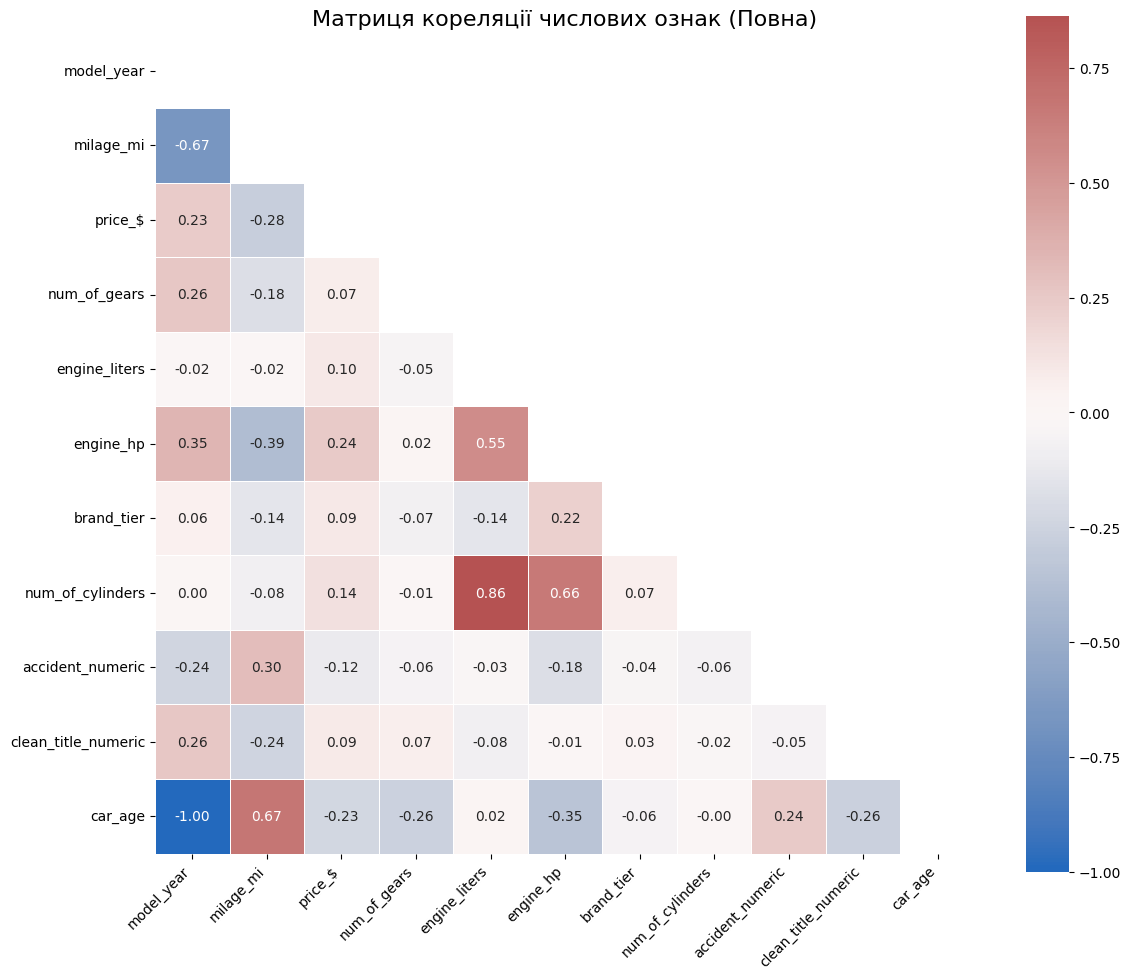

Матриця кореляції (Скорочена) збережена у 'correlation_heatmap_short.png'


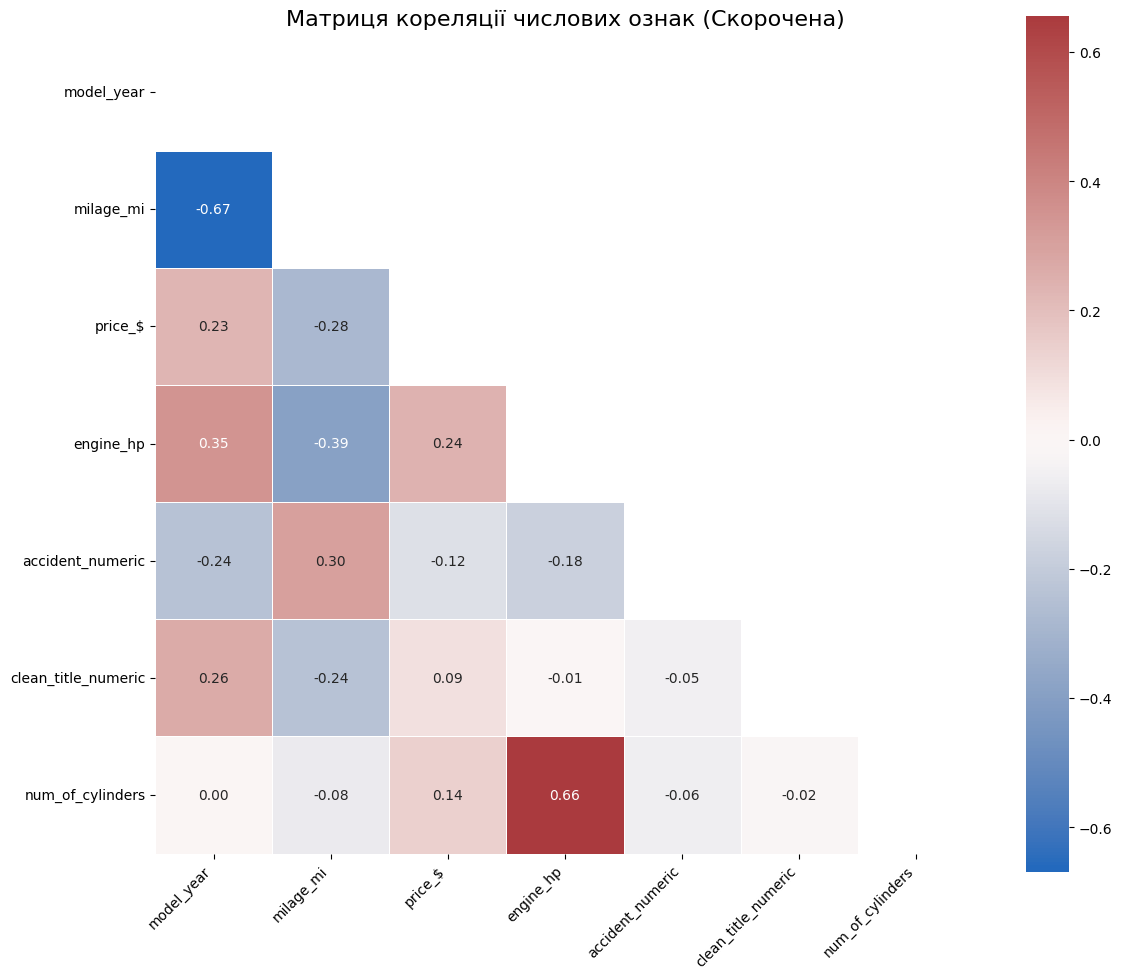

In [6]:
# (Перший графік)
numeric_cols_1 = [
    'model_year', 'milage_mi', 'price_$', 'num_of_gears',
    'engine_liters', 'engine_hp', 'brand_tier', 'num_of_cylinders',
    'accident_numeric', 'clean_title_numeric', 'car_age'
]
corr_matrix_1 = df[numeric_cols_1].corr()
plt.figure(figsize=(12, 10))
mask_1 = np.triu(np.ones_like(corr_matrix_1, dtype=bool))
sns.heatmap(corr_matrix_1, mask=mask_1, annot=True, fmt='.2f', cmap='vlag',
            center=0, square=True, linewidths=.5)
plt.title('Матриця кореляції числових ознак (Повна)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_heatmap_full.png')
print("Матриця кореляції (Повна) збережена у 'correlation_heatmap_full.png'")
plt.show() # Розкоментуйте, якщо потрібно показати

# (Другий графік)
numeric_cols_2 = [
    'model_year', 'milage_mi', 'price_$', 'engine_hp', 'accident_numeric', 'clean_title_numeric', 'num_of_cylinders'
]
corr_matrix_2 = df[numeric_cols_2].corr()
plt.figure(figsize=(12, 10))
mask_2 = np.triu(np.ones_like(corr_matrix_2, dtype=bool))
sns.heatmap(corr_matrix_2, mask=mask_2, annot=True, fmt='.2f', cmap='vlag',
            center=0, square=True, linewidths=.5)
plt.title('Матриця кореляції числових ознак (Скорочена)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_heatmap_short.png')
print("Матриця кореляції (Скорочена) збережена у 'correlation_heatmap_short.png'")
plt.show()

# --- КРОК 4: ПІДГОТОВКА ДО МОДЕЛЮВАННЯ ---

In [7]:
df_model = df.drop(columns={
    'accident',
    'clean_title',
    'engine_cylinders',
    'engine',
    'ext_col',
    'int_col',
    'model'
})
df_model = df_model.drop_duplicates()
print("\nФінальний DataFrame для моделі готовий:")

# Визначення ознак
categorical_features = [
    'brand', 'model_base', 'fuel_type', 'transmission_type',
    'ext_main_color', 'int_main_color', 'model_year'
]
numerical_features = [
    'milage_mi', 'num_of_gears', 'engine_hp', 'engine_liters', 'num_of_cylinders',
    'accident_numeric', 'clean_title_numeric', 'brand_tier', 'car_age'
]
TARGET = 'price_$'

for col in categorical_features:
    df_model[col] = df_model[col].astype(str).replace('nan', 'Unknown').astype('category')

# Зберігаємо список ознак ДО додавання прогнозу класифікатора
FEATURES_BEFORE_CLF = numerical_features + categorical_features

# Визначення Y (Цільових змінних)
y_reg_log = np.log1p(df_model[TARGET])

Q1 = df_model[TARGET].quantile(0.25)
Q3 = df_model[TARGET].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
y_clf_binary = (df_model[TARGET] < upper_bound).astype(int)

# X - це всі наші ознаки
FEATURES = numerical_features + categorical_features
X = df_model[FEATURES]

print(f"Дані підготовлено. Кількість ознак (до Етапу 1): {len(FEATURES)}")
print(f"Межа для 'викиду' ціни: ${upper_bound:,.0f}")

# Налаштування CV
N_FOLDS = 10
N_BAGS = 3
RANDOM_SEED = 42

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# --- Масиви для OOF-прогнозів ---
oof_clf_proba = np.zeros(len(X))
oof_reg_preds_1 = np.zeros(len(X)) # Модель 1 (LGBM5)
oof_reg_preds_2 = np.zeros(len(X)) # Модель 2 (LGBM1)
oof_reg_preds_3 = np.zeros(len(X)) # Модель 3 (CatBoost Reg)

# --- Списки для збереження навчених моделей ---
clf_models = []
reg_models_1 = [] # LGBM5
reg_models_2 = [] # LGBM1
reg_models_3 = [] # CatBoost Reg

print(f"Налаштовано {N_FOLDS}-fold CV з {N_BAGS} прогонами (Bags).")


Фінальний DataFrame для моделі готовий:
Дані підготовлено. Кількість ознак (до Етапу 1): 16
Межа для 'викиду' ціни: $99,250
Налаштовано 10-fold CV з 3 прогонами (Bags).


# --- КРОК 5: НАВЧАННЯ КЛАСИФІКАТОРА ---

In [8]:
# --- НАВЧАННЯ CATBOOST CLASSIFIER ---

cat_params = {
    'early_stopping_rounds': 50,
    'use_best_model': True,
    "verbose": 200,
    'cat_features': categorical_features,
    'min_data_in_leaf': 16,
    'learning_rate': 0.03355,
    'random_strength': 11.66,
    'l2_leaf_reg': 17.70,
    'max_depth': 10,
    'subsample': 0.9479,
    'border_count': 130,
    'bootstrap_type': 'Bernoulli',
    'task_type': "GPU", 
}

print("\nПочаток навчання Класифікатора (Етап 1)...")

for i in range(N_BAGS):
    print(f"--- BAG {i+1} / {N_BAGS} ---")
    current_seed = RANDOM_SEED + i
    skf_clf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=current_seed)
    
    for fold, (train_idx, val_idx) in enumerate(skf_clf.split(X, y_clf_binary), 1):
        print(f"  -- Fold {fold}/{N_FOLDS} --")
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y_clf_binary.iloc[train_idx], y_clf_binary.iloc[val_idx]

        model_clf = CatBoostClassifier(**cat_params, random_state=current_seed)
        model_clf.fit(X_train, y_train, eval_set=(X_val, y_val))
        
        oof_clf_proba[val_idx] += model_clf.predict_proba(X_val)[:, 1] / N_BAGS
        clf_models.append(model_clf)
        
auc_score = roc_auc_score(y_clf_binary, oof_clf_proba)
print(f"\n--- Етап 1 Завершено. OOF AUC Класифікатора: {auc_score:.4f} ---")

# Додаємо нову ознаку до X
X['price_is_low_feat'] = oof_clf_proba
numerical_features.append('price_is_low_feat')
FEATURES = numerical_features + categorical_features


Початок навчання Класифікатора (Етап 1)...
--- BAG 1 / 3 ---
  -- Fold 1/10 --
0:	learn: 0.6390628	test: 0.6384110	best: 0.6384110 (0)	total: 5.14s	remaining: 1h 25m 40s
200:	learn: 0.1492257	test: 0.1557063	best: 0.1557063 (200)	total: 24.2s	remaining: 1m 36s
400:	learn: 0.1449548	test: 0.1552698	best: 0.1552698 (400)	total: 43.5s	remaining: 1m 4s
bestTest = 0.1550785868
bestIteration = 520
Shrink model to first 521 iterations.
  -- Fold 2/10 --
0:	learn: 0.6407283	test: 0.6402147	best: 0.6402147 (0)	total: 53ms	remaining: 52.9s
200:	learn: 0.1494015	test: 0.1558568	best: 0.1558568 (200)	total: 18.8s	remaining: 1m 14s
400:	learn: 0.1454891	test: 0.1552837	best: 0.1552812 (398)	total: 38s	remaining: 56.7s
600:	learn: 0.1415968	test: 0.1551598	best: 0.1551494 (593)	total: 58.5s	remaining: 38.8s
bestTest = 0.1551127916
bestIteration = 634
Shrink model to first 635 iterations.
  -- Fold 3/10 --
0:	learn: 0.6408177	test: 0.6412119	best: 0.6412119 (0)	total: 53.6ms	remaining: 53.6s
200:	le

In [9]:
# --- КРОК 5.1: ФІНАЛІЗАЦІЯ НАБОРІВ ДАНИХ ДЛЯ РЕГРЕСОРІВ ТА OPTUNA ---

print("Створення фінальних наборів даних X_full, X_le, y_target_log_full...")

# 1. Створюємо X_full (з уже доданою 'price_is_low_feat' з Кроку 5)
X_full = X.copy() 
y_target_log_full = y_reg_log.copy()    # Повний логарифм ціни
y_clf_binary_full = y_clf_binary.copy() # Повний y для стратифікації
print(f"Створено X_full (shape: {X_full.shape})")

# 2. Визначаємо функцію Label Encoding (якщо вона ще не визначена)
if 'label_encoding' not in locals():
    def label_encoding(data, cat_cols_list, threshold):
        df = data.copy()
        le = LabelEncoder()
        print("Застосування Label Encoding...")
        for c in cat_cols_list:
            df[c] = df[c].astype(str)
            df[c] = le.fit_transform(df[c])
            df[c] -= df[c].min()
            vc = df[c].value_counts()
            RARE = vc.loc[vc < threshold].index.values
            df[c] += 1
            df.loc[df[c].isin(RARE), c] = 0
        return df

# 3. Створюємо X_le (Label Encoded версія X_full)
X_le = label_encoding(X_full, cat_cols_list=categorical_features, threshold=5)
print(f"Створено X_le (shape: {X_le.shape})")

print("\nВсі дані готові для Optuna та навчання регресорів.")

Створення фінальних наборів даних X_full, X_le, y_target_log_full...
Створено X_full (shape: (192428, 17))
Застосування Label Encoding...
Створено X_le (shape: (192428, 17))

Всі дані готові для Optuna та навчання регресорів.


In [10]:
fffj

NameError: name 'fffj' is not defined

# --- КРОК 6: (ДОДАТКОВО) ОПТИМІЗАЦІЯ ГІПЕРПАРАМЕТРІВ (OPTUNA) ---

In [16]:
# --- КРОК 6: (ДОДАТКОВО) ОПТИМІЗАЦІЯ ГІПЕРПАРАМЕТРІВ (OPTUNA) ---
#
# ІНСТРУКЦІЯ:
# 1. Запустіть усі попередні клітинки (до Кроку 4 включно), щоб підготувати дані.
# 2. Розкоментуйте ОДИН із блоків "Запуск дослідження" нижче.
# 3. Запустіть ЦЮ клітинку і дочекайтеся завершення (це може бути довго).
# 4. Скопіюйте отримані "Найкращі параметри".
# 5. Вставте їх у відповідний словник параметрів у Кроках 7.1, 7.2 або 7.3.
# 6. Закоментуйте блок "Запуск дослідження" назад, щоб не запускати його випадково.
# 7. Тепер ви можете запускати весь ноутбук, і він буде використовувати оптимізовані параметри.
# --------------------------------------------------------------------------------------

# --- Підготовка даних для Optuna (один фолд для швидкості) ---
# Створюємо валідаційний набір, який буде однаковим для всіх тріалів
skf_opt = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)
train_idx, val_idx = next(iter(skf_opt.split(X_full, y_clf_binary_full)))

# Дані для моделей з нативною підтримкою категорій (LGBM1, CatBoost)
X_train_full_opt = X_full.iloc[train_idx]
X_val_full_opt = X_full.iloc[val_idx]
y_train_log_opt = y_target_log_full.iloc[train_idx]
y_val_log_opt = y_target_log_full.iloc[val_idx]

# Дані для моделей, що потребують Label Encoding (LGBM5)
X_train_le_opt = X_le.iloc[train_idx]
X_val_le_opt = X_le.iloc[val_idx]

print("Валідаційні дані для Optuna готові.")

# --- Objective для LGBM5 (Модель 1) ---
def objective_lgbm5(trial):
    params = {
        'objective': 'regression_l1', 'metric': 'rmse', 'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'max_bin': trial.suggest_int('max_bin', 255, 30000),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'n_jobs': -1, 'random_state': RANDOM_SEED, 'verbose': -1
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train_le_opt, y_train_log_opt, eval_set=[(X_val_le_opt, y_val_log_opt)], callbacks=[lgb.early_stopping(50, verbose=False)])
    preds = model.predict(X_val_le_opt)
    return np.sqrt(mean_squared_error(y_val_log_opt, preds))

# --- Objective для LGBM1 (Модель 2) ---
def objective_lgbm1(trial):
    params = {
        'objective': 'regression_l1', 'metric': 'rmse', 'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.03),
        'num_leaves': trial.suggest_int('num_leaves', 200, 600),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 50, 150),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'n_jobs': -1, 'random_state': RANDOM_SEED, 'verbose': -1
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train_full_opt, y_train_log_opt, eval_set=[(X_val_full_opt, y_val_log_opt)], callbacks=[lgb.early_stopping(50, verbose=False)], categorical_feature=categorical_features)
    preds = model.predict(X_val_full_opt)
    return np.sqrt(mean_squared_error(y_val_log_opt, preds))

# --- Objective для CatBoost (Модель 3) ---
def objective_catboost(trial):
    params = {
        'loss_function': 'RMSE', 'n_estimators': 20000, 'early_stopping_rounds': 50,
        'task_type': 'GPU', 'verbose': False, 'random_state': RANDOM_SEED,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'max_depth': trial.suggest_int('max_depth', 6, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 30.0, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 50),
        'random_strength': trial.suggest_float('random_strength', 1.0, 20.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 30.0),
    }
    model = cb.CatBoostRegressor(**params, cat_features=categorical_features)
    model.fit(X_train_full_opt, y_train_log_opt, eval_set=[(X_val_full_opt, y_val_log_opt)])
    preds = model.predict(X_val_full_opt)
    return np.sqrt(mean_squared_error(y_val_log_opt, preds))


# -----------------------------------------------------------------
# ЗАПУСК ДОСЛІДЖЕНЬ (розкоментуйте потрібний блок)
# -----------------------------------------------------------------

# # --- Запуск дослідження для LGBM5 (Модель 1) ---
# print("Запуск Optuna для LGBM5 (Модель 1)...")
# study_lgbm5 = optuna.create_study(direction='minimize')
# study_lgbm5.optimize(objective_lgbm5, n_trials=100) # Спробуйте 50-100 тріалів
#
# print(f"Найкращий RMSE для LGBM5: {study_lgbm5.best_value}")
# print(f"Найкращі параметри для LGBM5:")
# print(study_lgbm5.best_params)


# # --- Запуск дослідження для LGBM1 (Модель 2) ---
# print("\nЗапуск Optuna для LGBM1 (Модель 2)...")
# study_lgbm1 = optuna.create_study(direction='minimize')
# study_lgbm1.optimize(objective_lgbm1, n_trials=100) # Спробуйте 50-100 тріалів
#
# print(f"Найкращий RMSE для LGBM1: {study_lgbm1.best_value}")
# print(f"Найкращі параметри для LGBM1:")
# print(study_lgbm1.best_params)


# # --- Запуск дослідження для CatBoost (Модель 3) ---
# print("\nЗапуск Optuna для CatBoost (Модель 3)...")
# study_catboost = optuna.create_study(direction='minimize')
# study_catboost.optimize(objective_catboost, n_trials=100) # CatBoost повільніший, почніть з 30
#
# print(f"Найкращий RMSE для CatBoost: {study_catboost.best_value}")
# print(f"Найкращі параметри для CatBoost:")
# print(study_catboost.best_params)

print("\nКлітинка Optuna готова до запуску (всі дослідження закоментовано).")
print("Розкоментуйте потрібний блок, щоб почати пошук параметрів.")

Валідаційні дані для Optuna готові.

Клітинка Optuna готова до запуску (всі дослідження закоментовано).
Розкоментуйте потрібний блок, щоб почати пошук параметрів.


# --- КРОК 7: НАВЧАННЯ РЕГРЕСОРІВ ---

In [17]:
# --- КРОК 7.1: НАВЧАННЯ LGBM REGRESSOR (МОДЕЛЬ 1) ---

def label_encoding(data, cat_cols_list, threshold):
    df = data.copy()
    le = LabelEncoder()
    print("Застосування Label Encoding...")
    for c in cat_cols_list:
        df[c] = df[c].astype(str)
        df[c] = le.fit_transform(df[c])
        df[c] -= df[c].min()
        vc = df[c].value_counts()
        RARE = vc.loc[vc < threshold].index.values
        df[c] += 1
        df.loc[df[c].isin(RARE), c] = 0
    return df

lgb_params5 = {
    'objective': 'regression_l1', # або 'regression_l1' (MAE), якщо ви його використовували в Optuna
    'metric': 'rmse',
    'n_estimators': 2000,
    'early_stopping_round': 50,
    'learning_rate': 0.023997170627003427,
    'num_leaves': 227,
    'max_bin': 16821,
    'subsample': 0.9729362350115525,
    'colsample_bytree': 0.7007843685843634,
    'min_child_samples': 80,
    'n_jobs': -1,
    'verbose': -1
}

print("\nПідготовка до Етапу 2 (LGBM5 - Модель 1)...")

X_le = label_encoding(X[FEATURES], cat_cols_list=categorical_features, threshold=5)

print("Початок навчання Регресора (Етап 2)...")

for i in range(N_BAGS):
    print(f"--- BAG {i+1} / {N_BAGS} ---")
    current_seed = RANDOM_SEED + i
    skf_reg = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=current_seed)
    
    for fold, (train_idx, val_idx) in enumerate(skf_reg.split(X_le, y_clf_binary), 1):
        print(f"  -- Fold {fold}/{N_FOLDS} --")
        
        X_train, X_val = X_le.iloc[train_idx], X_le.iloc[val_idx]
        y_train, y_val = y_reg_log.iloc[train_idx], y_reg_log.iloc[val_idx]
        
        model_reg = LGBMRegressor(**lgb_params5, random_state=current_seed)
        
        model_reg.fit(X_train, y_train,
                      eval_set=[(X_val, y_val)],
                      callbacks=[lgb.log_evaluation(period=500)])
        
        oof_reg_preds_1[val_idx] += model_reg.predict(X_val) / N_BAGS
        reg_models_1.append(model_reg)

print("\n--- Етап 2 (Модель 1) Завершено. ---")

# --- ОЦІНКА МОДЕЛІ 1 (НА ВСІХ ДАНИХ) ---
print("\n--- РЕЗУЛЬТАТИ МОДЕЛІ 1 (LGBM5) (OOF на train+original) ---")
oof_preds_original_model1_full = np.expm1(oof_reg_preds_1)
rmse_model1_full = np.sqrt(mean_squared_error(df_model[TARGET], oof_preds_original_model1_full))
mae_model1_full = mean_absolute_error(df_model[TARGET], oof_preds_original_model1_full)

print(f"OOF RMSE (Помилка $): {rmse_model1_full:.2f}")
print(f"OOF MAE (Помилка $):  {mae_model1_full:.2f}\n")


Підготовка до Етапу 2 (LGBM5 - Модель 1)...
Застосування Label Encoding...
Початок навчання Регресора (Етап 2)...
--- BAG 1 / 3 ---
  -- Fold 1/10 --
[500]	valid_0's rmse: 0.48326
  -- Fold 2/10 --
[500]	valid_0's rmse: 0.496054
  -- Fold 3/10 --
[500]	valid_0's rmse: 0.485973
  -- Fold 4/10 --
[500]	valid_0's rmse: 0.483131
  -- Fold 5/10 --
[500]	valid_0's rmse: 0.483335
  -- Fold 6/10 --
[500]	valid_0's rmse: 0.486145
  -- Fold 7/10 --
[500]	valid_0's rmse: 0.488832
  -- Fold 8/10 --
[500]	valid_0's rmse: 0.501903
[1000]	valid_0's rmse: 0.50131
  -- Fold 9/10 --
[500]	valid_0's rmse: 0.483565
  -- Fold 10/10 --
[500]	valid_0's rmse: 0.479032
--- BAG 2 / 3 ---
  -- Fold 1/10 --
[500]	valid_0's rmse: 0.481726
  -- Fold 2/10 --
[500]	valid_0's rmse: 0.488456
  -- Fold 3/10 --
[500]	valid_0's rmse: 0.484439
  -- Fold 4/10 --
[500]	valid_0's rmse: 0.483644
  -- Fold 5/10 --
[500]	valid_0's rmse: 0.496026
  -- Fold 6/10 --
[500]	valid_0's rmse: 0.491506
  -- Fold 7/10 --
[500]	valid_0's 

In [12]:
# --- КРОК 7.2: НАВЧАННЯ МОДЕЛІ 2 (LGBM1) ---

print("\nВідновлюємо змінні для Моделей 2, 3, 4...")
# X вже містить нову фічу 'price_is_low_feat'
X_full = X.copy() 
y_target_log_full = y_reg_log.copy()    # Повний логарифм ціни
y_clf_binary_full = y_clf_binary.copy() # Повний y для стратифікації

print(f"Повний X (X_full) shape: {X_full.shape}")

lgb_params1 = {
    'objective': 'regression_l1',
    'metric': 'rmse',
    'n_estimators': 2000,
    'early_stopping_round': 50,
    'learning_rate': 0.01823700419414591,
    'num_leaves': 416,
    'subsample': 0.9716914679695505,
    'colsample_bytree': 0.7110963652306839,
    'min_data_in_leaf': 61,
    'reg_alpha': 6.341258689888004e-05,
    'reg_lambda': 0.00341440289172701,
    'n_jobs': -1,
    'verbose': -1
}

print("\n===== Початок навчання Моделі 2 (LGBM1) [CV по всіх даних] =====\n")

for i in range(N_BAGS):
    print(f"--- BAG {i+1}/{N_BAGS} ---")
    current_seed = RANDOM_SEED + i
    skf_reg_2 = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=current_seed)

    for fold, (train_idx, val_idx) in enumerate(skf_reg_2.split(X_full, y_clf_binary_full), 1):
        print(f"  -- Fold {fold}/{N_FOLDS} --")

        X_train, X_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
        y_train, y_val = y_target_log_full.iloc[train_idx], y_target_log_full.iloc[val_idx]
        
        model_reg_2 = LGBMRegressor(**lgb_params1, random_state=current_seed)
        model_reg_2.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.log_evaluation(period=500)],
            categorical_feature=categorical_features 
        )
        
        oof_reg_preds_2[val_idx] += model_reg_2.predict(X_val) / N_BAGS
        reg_models_2.append(model_reg_2)

print("\n===== Модель 2 (LGBM1) Завершено =====")
oof_lgbm1_original = np.expm1(oof_reg_preds_2)
rmse_lgbm1 = np.sqrt(mean_squared_error(df_model[TARGET], oof_lgbm1_original))
print(f"\nOOF RMSE (LGBM1 Модель 2): {rmse_lgbm1:.2f}\n")


Відновлюємо змінні для Моделей 2, 3, 4...
Повний X (X_full) shape: (192428, 17)

===== Початок навчання Моделі 2 (LGBM1) [CV по всіх даних] =====

--- BAG 1/3 ---
  -- Fold 1/10 --
  -- Fold 2/10 --
  -- Fold 3/10 --
  -- Fold 4/10 --
  -- Fold 5/10 --
[500]	valid_0's rmse: 0.485541
  -- Fold 6/10 --
  -- Fold 7/10 --
  -- Fold 8/10 --
  -- Fold 9/10 --
  -- Fold 10/10 --
[500]	valid_0's rmse: 0.480489
--- BAG 2/3 ---
  -- Fold 1/10 --
[500]	valid_0's rmse: 0.48341
  -- Fold 2/10 --
  -- Fold 3/10 --
[500]	valid_0's rmse: 0.48621
  -- Fold 4/10 --
  -- Fold 5/10 --
  -- Fold 6/10 --
  -- Fold 7/10 --
  -- Fold 8/10 --
  -- Fold 9/10 --
[500]	valid_0's rmse: 0.49005
  -- Fold 10/10 --
--- BAG 3/3 ---
  -- Fold 1/10 --
  -- Fold 2/10 --
[500]	valid_0's rmse: 0.486083
  -- Fold 3/10 --
  -- Fold 4/10 --
[500]	valid_0's rmse: 0.483588
  -- Fold 5/10 --
  -- Fold 6/10 --
[500]	valid_0's rmse: 0.494273
  -- Fold 7/10 --
[500]	valid_0's rmse: 0.488147
  -- Fold 8/10 --
[500]	valid_0's rmse: 

In [18]:
# --- КРОК 7.3: НАВЧАННЯ МОДЕЛІ 3 (CatBoost) ---

catboost_params = {
    'loss_function': "RMSE",
    'learning_rate': 0.03355311405703999,
    'min_data_in_leaf': 16,
    'l2_leaf_reg': 17.703146378123996,
    'random_strength': 11.663619399375248,
    'max_depth': 10,
    'border_count': 130,
    'bagging_temperature': 24.032067560148384,
    'n_estimators': 20000,
    'early_stopping_rounds': 25,
    'cat_features': categorical_features,
    'verbose': False,
    'task_type': 'GPU'
}

print("\n===== Початок навчання Моделі 3 (CatBoost) [CV по всіх даних] =====\n")

for i in range(N_BAGS):
    print(f"--- BAG {i+1}/{N_BAGS} ---")
    current_seed = RANDOM_SEED + i
    kf_3 = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=current_seed)

    for fold, (train_idx, val_idx) in enumerate(kf_3.split(X_full, y_clf_binary_full), 1):
        print(f"  -- Fold {fold}/{N_FOLDS} --")

        X_train, X_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
        y_train, y_val = y_target_log_full.iloc[train_idx], y_target_log_full.iloc[val_idx]
        
        model_reg_3 = CatBoostRegressor(**catboost_params, random_state=current_seed)
        model_reg_3.fit(
            X_train,
            y_train,
            eval_set=(X_val, y_val)
        )
        
        oof_reg_preds_3[val_idx] += model_reg_3.predict(X_val) / N_BAGS
        reg_models_3.append(model_reg_3)

print("\n===== Модель 3 (CatBoost) Завершено =====")
oof_catboost_original = np.expm1(oof_reg_preds_3)
rmse_catboost = np.sqrt(mean_squared_error(df_model[TARGET], oof_catboost_original))
print(f"\nOOF RMSE (CatBoost Модель 3): {rmse_catboost:.2f}\n")


===== Початок навчання Моделі 3 (CatBoost) [CV по всіх даних] =====

--- BAG 1/3 ---
  -- Fold 1/10 --
  -- Fold 2/10 --
  -- Fold 3/10 --
  -- Fold 4/10 --
  -- Fold 5/10 --
  -- Fold 6/10 --
  -- Fold 7/10 --
  -- Fold 8/10 --
  -- Fold 9/10 --
  -- Fold 10/10 --
--- BAG 2/3 ---
  -- Fold 1/10 --
  -- Fold 2/10 --
  -- Fold 3/10 --
  -- Fold 4/10 --
  -- Fold 5/10 --
  -- Fold 6/10 --
  -- Fold 7/10 --
  -- Fold 8/10 --
  -- Fold 9/10 --
  -- Fold 10/10 --
--- BAG 3/3 ---
  -- Fold 1/10 --
  -- Fold 2/10 --
  -- Fold 3/10 --
  -- Fold 4/10 --
  -- Fold 5/10 --
  -- Fold 6/10 --
  -- Fold 7/10 --
  -- Fold 8/10 --
  -- Fold 9/10 --
  -- Fold 10/10 --

===== Модель 3 (CatBoost) Завершено =====

OOF RMSE (CatBoost Модель 3): 73358.82



# --- КРОК 8: ФІНАЛЬНИЙ АНСАМБЛЬ (Ridge Stacking) ---

In [31]:
print("--- КРОК 8: ФІНАЛЬНИЙ АНСАМБЛЬ (Ridge Stacking) [На всіх даних] ---")

# 1. Створюємо DataFrame з OOF-прогнозів (в логарифмах)
oof_df = pd.DataFrame({
    'model_1_lgbm5': oof_reg_preds_1,
    'model_2_lgbm1': oof_reg_preds_2,
    'model_3_cat': oof_reg_preds_3,
})

# 2. Ціль — реальні логарифмовані ціни (ПОВНІ)
y_target_log = y_target_log_full

# 3. Ridge — знаходить найкращі ваги
alphas_to_try = np.logspace(-3, 2, 50)
ridge = RidgeCV(alphas=alphas_to_try, fit_intercept=True)
ridge.fit(oof_df, y_target_log)

# 4. OOF ансамблю (в логах)
oof_final_log = ridge.predict(oof_df)

print("\nВаги моделей (чим більше — тим важливіша модель):")
print(f"LGBM5 (Модель 1):    {ridge.coef_[0]:.4f}")
print(f"LGBM1 (Модель 2):    {ridge.coef_[1]:.4f}")
print(f"CatBoost (Модель 3): {ridge.coef_[2]:.4f}")

# ---- ФІНАЛЬНА ОЦІНКА АНСАМБЛЮ ----
oof_final_original = np.expm1(oof_final_log)

rmse_final = np.sqrt(mean_squared_error(df_model[TARGET], oof_final_original))
mae_final = mean_absolute_error(df_model[TARGET], oof_final_original)

print("\n--- РЕЗУЛЬТАТИ АНСАМБЛЮ (4 моделі на train+original) ---")
print(f"OOF RMSE:    {rmse_final:.2f}")
print(f"OOF MAE:     {mae_final:.2f}")

--- КРОК 8: ФІНАЛЬНИЙ АНСАМБЛЬ (Ridge Stacking) [На всіх даних] ---

Ваги моделей (чим більше — тим важливіша модель):
LGBM5 (Модель 1):    0.6785
LGBM1 (Модель 2):    0.1876
CatBoost (Модель 3): 0.1575

--- РЕЗУЛЬТАТИ АНСАМБЛЮ (4 моделі на train+original) ---
OOF RMSE:    73225.27
OOF MAE:     16937.70


# --- КРОК 9: КОРЕКТНЕ ПОРІВНЯННЯ ВСІХ МОДЕЛЕЙ ---

In [32]:
print("\n--- КРОК 9: КОРЕКТНЕ ПОРІВНЯННЯ RMSE (на всіх даних train+original) ---")

# 1. RMSE Моделі 1 (LGBM5)
#    (rmse_model1_full - з Кроку 7.1)

# 2. RMSE Моделі 2 (LGBM1)
#    (rmse_lgbm1 - з Кроку 7.2)

# 3. RMSE Моделі 3 (CatBoost)
#    (rmse_catboost - з Кроку 7.3)

# 4. RMSE Ансамблю (Ridge)
#    (rmse_final - з Кроку 8)

print(f"RMSE Моделі 1 (LGBM5):    {rmse_model1_full:.2f}")
print(f"RMSE Моделі 2 (LGBM1):    {rmse_lgbm1:.2f}")
print(f"RMSE Моделі 3 (CatBoost): {rmse_catboost:.2f}")
print("--------------------------------------------------")
print(f"RMSE Ансамблю (Ridge):   {rmse_final:.2f}")
print("--------------------------------------------------")

best_rmse = min(rmse_model1_full, rmse_lgbm1, rmse_catboost, rmse_final)
print(f"Найкращий OOF RMSE (на всіх даних): {best_rmse:.2f}")


--- КРОК 9: КОРЕКТНЕ ПОРІВНЯННЯ RMSE (на всіх даних train+original) ---
RMSE Моделі 1 (LGBM5):    73441.26
RMSE Моделі 2 (LGBM1):    73561.18
RMSE Моделі 3 (CatBoost): 73358.82
--------------------------------------------------
RMSE Ансамблю (Ridge):   73225.27
--------------------------------------------------
Найкращий OOF RMSE (на всіх даних): 73225.27


# --- КРОК 10: (ДОДАТКОВО) АНАЛІЗ ВАЖЛИВОСТІ ОЗНАК ---

Аналіз важливості ознак (на основі збережених моделей)...

--- Модель 1 (LGBM5) Feature Importance ---


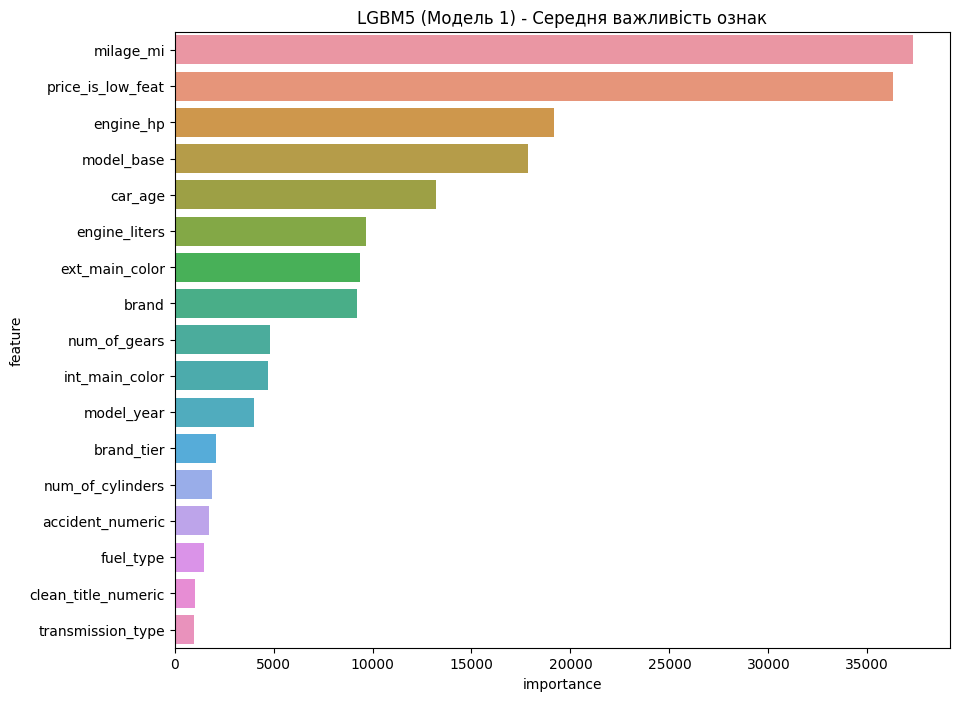

--- Модель 2 (LGBM1) Feature Importance ---


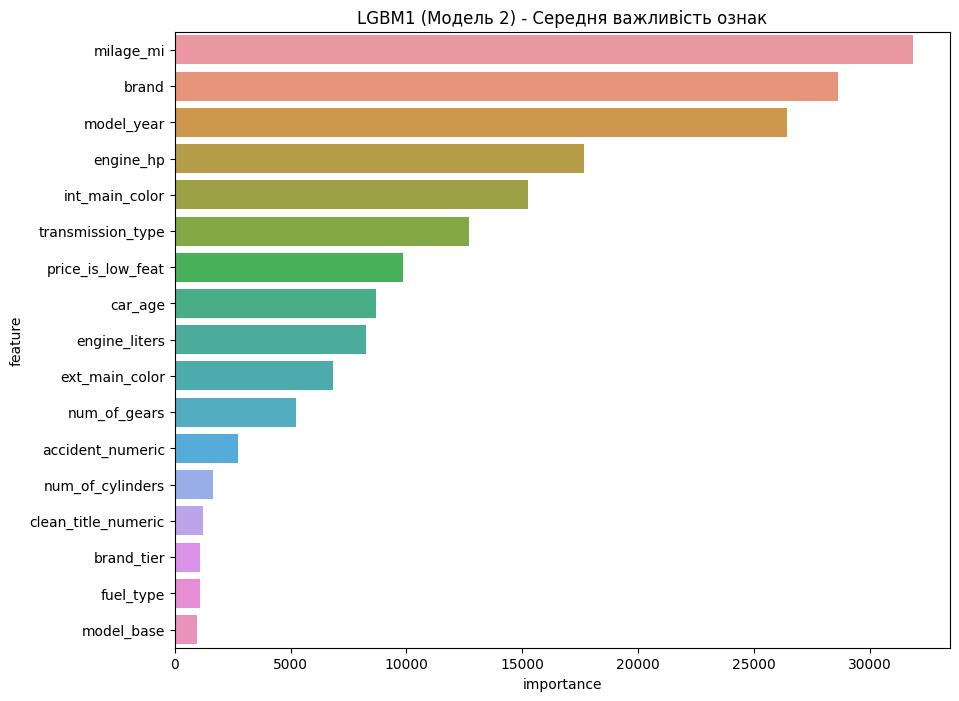


--- Модель 3 (CatBoost) Feature Importance ---


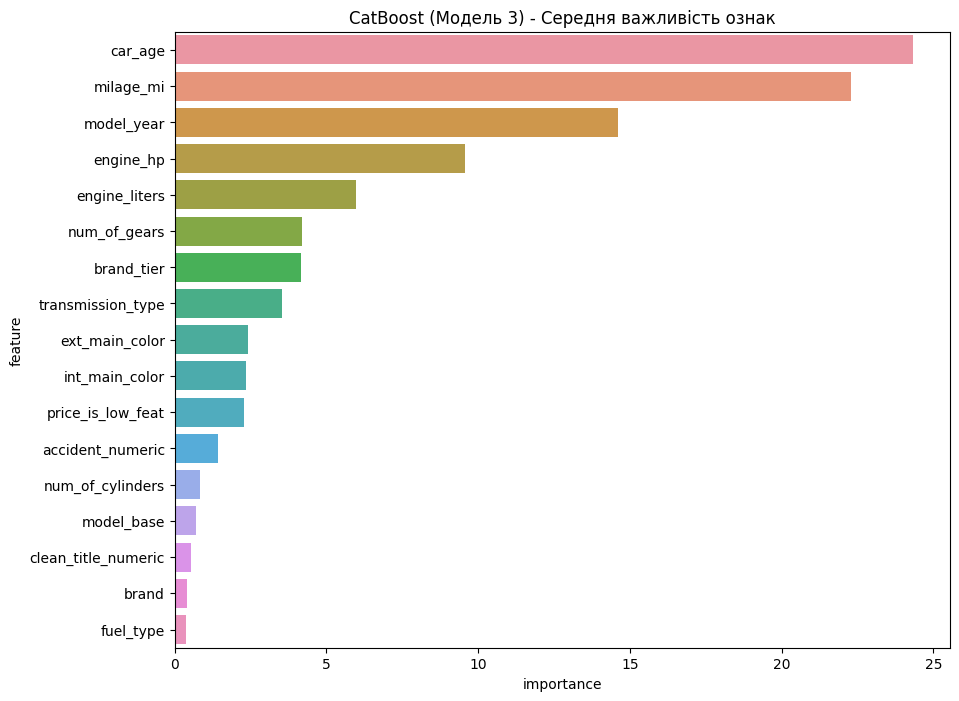

In [22]:
print("Аналіз важливості ознак (на основі збережених моделей)...\n")

# --- Важливість для Моделі 1 (LGBM5) ---
if 'reg_models_1' in locals() and len(reg_models_2) > 0:
    print("--- Модель 1 (LGBM5) Feature Importance ---")
    feature_importance_df_lgbm5 = pd.DataFrame()
    feature_importance_df_lgbm5['feature'] = FEATURES
    feature_importance_df_lgbm5['importance'] = 0
    
    for model in reg_models_1:
        feature_importance_df_lgbm5['importance'] += model.feature_importances_
        
    feature_importance_df_lgbm5['importance'] /= len(reg_models_1)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(
        x='importance', 
        y='feature', 
        data=feature_importance_df_lgbm5.sort_values(by='importance', ascending=False)
    )
    plt.title('LGBM5 (Модель 1) - Середня важливість ознак')
    plt.show()

# --- Важливість для Моделі 2 (LGBM1) ---
if 'reg_models_2' in locals() and len(reg_models_2) > 0:
    print("--- Модель 2 (LGBM1) Feature Importance ---")
    feature_importance_df_lgbm1 = pd.DataFrame()
    feature_importance_df_lgbm1['feature'] = FEATURES
    feature_importance_df_lgbm1['importance'] = 0
    
    for model in reg_models_2:
        feature_importance_df_lgbm1['importance'] += model.feature_importances_
        
    feature_importance_df_lgbm1['importance'] /= len(reg_models_2)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(
        x='importance', 
        y='feature', 
        data=feature_importance_df_lgbm1.sort_values(by='importance', ascending=False)
    )
    plt.title('LGBM1 (Модель 2) - Середня важливість ознак')
    plt.show()

# --- Важливість для Моделі 3 (CatBoost) ---
if 'reg_models_3' in locals() and len(reg_models_3) > 0:
    print("\n--- Модель 3 (CatBoost) Feature Importance ---")
    
    feature_importance_df_cat = pd.DataFrame()
    feature_importance_df_cat['feature'] = FEATURES
    feature_importance_df_cat['importance'] = 0
    
    for model in reg_models_3:
        feature_importance_df_cat['importance'] += model.get_feature_importance()
        
    feature_importance_df_cat['importance'] /= len(reg_models_3)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(
        x='importance', 
        y='feature', 
        data=feature_importance_df_cat.sort_values(by='importance', ascending=False)
    )
    plt.title('CatBoost (Модель 3) - Середня важливість ознак')
    plt.show()


--- Матриця кореляції OOF-прогнозів (логарифми) ---


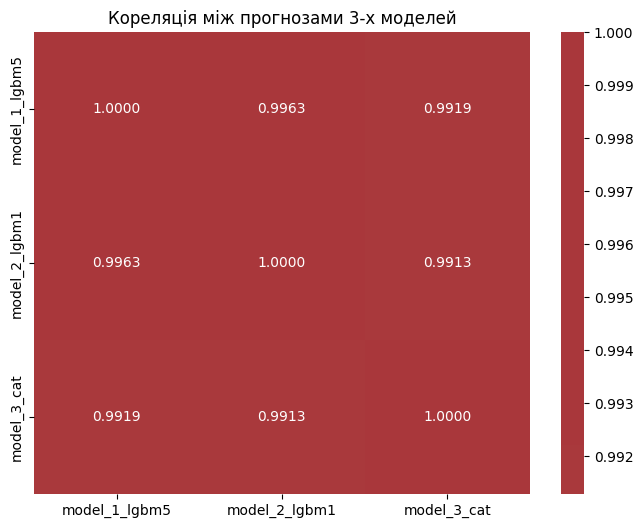

In [25]:
# --- АНАЛІЗ КОРЕЛЯЦІЇ OOF-ПРОГНОЗІВ ---
print("\n--- Матриця кореляції OOF-прогнозів (логарифми) ---")

plt.figure(figsize=(8, 6))
sns.heatmap(
    oof_df.corr(), 
    annot=True, 
    fmt='.4f', 
    cmap='vlag', 
    center=0
)
plt.title("Кореляція між прогнозами 3-х моделей")
plt.show()

# --- КРОК 11: ФІНАЛЬНИЙ ПРОГНОЗ НА ТЕСТОВИХ ДАНИХ ---

In [33]:
print("--- Початок прогнозування на тестових даних ---")

# Завантажуємо тестові дані
try:
    df_test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
    test_ids = df_test['id'] # Зберігаємо id для submission файлу
    df_test = df_test.drop(columns=['id'])
    print(f"Тестові дані завантажено. Кількість рядків: {len(df_test)}")
except FileNotFoundError:
    print("Помилка: Тестовий файл не знайдено. Прогноз неможливий.")
    # Якщо ви запускаєте локально, переконайтеся, що файл test.csv лежить у правильній папці.
    df_test = None

if df_test is not None:
    # -----------------------------------------------------------------------------
    # !!! ВАЖЛИВО: Повторюємо ВСІ кроки Feature Engineering та Imputation !!!
    # -----------------------------------------------------------------------------

    df_test = df_test.rename(columns={"milage": "milage_mi"})
    df_test['fuel_type'] = df_test['fuel_type'].replace({'–': 'Unknown', 'not supported': 'Unknown', np.nan: 'Unknown'})

    # Використовуємо функції 'classify_transmission' та 'replacements' з КРОКУ 2
    df_test['transmission'] = df_test['transmission'].str.lower()
    df_test['transmission'] = df_test['transmission'].replace(replacements, regex=True)
    df_test['num_of_gears'] = df_test['transmission'].str.extract(r'(\d{1,2})[ -]?(?:speed|spd)')[0]
    df_test['transmission_type'] = df_test['transmission'].apply(classify_transmission)
    df_test['transmission_type'] = df_test.groupby('brand')['transmission_type'].transform(fill_transmission)
    df_test = df_test.drop(columns=['transmission'])

    # Використовуємо 'extract_main_color' та 'map_color' з КРОКУ 2
    df_test['ext_main_color'] = df_test['ext_col'].apply(extract_main_color).str.lower()
    df_test['int_main_color'] = df_test['int_col'].str.lower().apply(map_color)

    # Використовуємо 'accident_map' з КРОКУ 2
    df_test['accident'] = df_test['accident'].replace({'None reported': 'No', 'At least 1 accident or damage reported': 'Yes', np.nan: 'Unknown'})
    df_test['accident_numeric'] = df_test['accident'].map(accident_map)

    # Використовуємо 'title_map' з КРОКУ 2
    df_test['clean_title'] = df_test['clean_title'].replace({np.nan: "Unknown"})
    df_test['clean_title_numeric'] = df_test['clean_title'].map(title_map)

    df_test['engine'] = df_test['engine'].str.lower()
    df_test['engine_liters'] = df_test['engine'].str.extract(r'(\d\.\d)[ ]?(?:l|liter)')[0]
    df_test['engine_cylinders'] = df_test['engine'].str.extract(r'((?:v|i|h|w|flat)\d{1,2}|\d{1,2}[ -]cylinder)')[0]
    df_test['engine_hp'] = df_test['engine'].str.extract(r'(\d{1,4}\.\d)hp')[0]

    df_test['brand_tier'] = df_test['brand'].apply(classify_brand_tier)
    df_test["model"] = df_test["model"].str.lower().apply(remove_all_duplicate_words)
    df_test['model_base'] = df_test['model'].str.extract(r'^([a-z0-9-]+)')[0]
    
    df_test['car_age'] = 2025 - df_test['model_year'] # <-- ДОДАНО

    # --- Заповнення пропусків (Imputation) ---
    # Використовуємо середні/моди, розраховані на df_model (з КРОКУ 4)
    df_test['engine_liters'] = pd.to_numeric(df_test['engine_liters'], errors='coerce')
    df_test['engine_liters'] = df_test['engine_liters'].fillna(df_model['engine_liters'].mean())

    df_test['num_of_cylinders'] = df_test['engine_cylinders'].str.extract(r'(\d+)')
    df_test['num_of_cylinders'] = pd.to_numeric(df_test['num_of_cylinders'], errors='coerce')
    df_test['num_of_cylinders'] = df_test['num_of_cylinders'].fillna(df_model['num_of_cylinders'].mode()[0])
    df_test['num_of_cylinders'] = df_test['num_of_cylinders'].round().astype('int64')

    df_test['engine_hp'] = pd.to_numeric(df_test['engine_hp'], errors='coerce')
    df_test['engine_hp'] = df_test['engine_hp'].fillna(df_model['engine_hp'].mean())
    df_test['engine_hp'] = df_test['engine_hp'].round().astype(int)

    df_test['num_of_gears'] = pd.to_numeric(df_test['num_of_gears'], errors='coerce')
    df_test['num_of_gears'] = df_test['num_of_gears'].fillna(df_model['num_of_gears'].mode()[0])
    df_test['num_of_gears'] = df_test['num_of_gears'].astype(int)

    # -----------------------------------------------------------------------------
    # ЕТАП 1: Прогноз класифікатора
    # -----------------------------------------------------------------------------
    # Використовуємо список ознак, який ми зберегли у КРОЦІ 4
    X_test = df_test[FEATURES_BEFORE_CLF] 
    for col in categorical_features:
        X_test[col] = X_test[col].astype(str).replace('nan', 'Unknown').astype('category')

    print("Інженерія ознак для тестових даних завершена.")

    test_clf_proba = np.zeros(len(X_test))
    for model in clf_models:
        test_clf_proba += model.predict_proba(X_test)[:, 1] / len(clf_models)

    X_test['price_is_low_feat'] = test_clf_proba
    print("Етап 1 (Класифікатор) на тестових даних виконано.")

    # -----------------------------------------------------------------------------
    # ЕТАП 2: Прогноз регресорів
    # -----------------------------------------------------------------------------

    # --- Прогноз Моделі 1 (LGBM5) ---
    X_test_le = label_encoding(X_test, cat_cols_list=categorical_features, threshold=5)
    test_reg_preds_1 = np.zeros(len(X_test_le))
    for model in reg_models_1:
        test_reg_preds_1 += model.predict(X_test_le) / len(reg_models_1)
    print("Прогноз Моделі 1 (LGBM5) готовий.")

    # --- Прогноз Моделі 2 (LGBM1) ---
    test_reg_preds_2 = np.zeros(len(X_test))
    for model in reg_models_2:
        test_reg_preds_2 += model.predict(X_test) / len(reg_models_2)
    print("Прогноз Моделі 2 (LGBM1) готовий.")

    # --- Прогноз Моделі 3 (CatBoost) ---
    test_reg_preds_3 = np.zeros(len(X_test))
    for model in reg_models_3:
        test_reg_preds_3 += model.predict(X_test) / len(reg_models_3)
    print("Прогноз Моделі 3 (CatBoost) готовий.")

    # -----------------------------------------------------------------------------
    # ЕТАП 3: Фінальний ансамбль (Ridge)
    # -----------------------------------------------------------------------------
    # Використовуємо 'ridge' модель, навчену в КРОЦІ 7
    test_oof_df = pd.DataFrame({
        'model_1_lgbm5': test_reg_preds_1,
        'model_2_lgbm1': test_reg_preds_2,
        'model_3_cat': test_reg_preds_3,
    })

    final_test_preds_log = ridge.predict(test_oof_df)
    final_test_preds = np.expm1(final_test_preds_log)
    final_test_preds[final_test_preds < 0] = 0
    print("Фінальний прогноз ансамблю готовий.")

    # -----------------------------------------------------------------------------
    # ЕТАП 4: Створення файлу для відправки
    # -----------------------------------------------------------------------------
    submission = pd.DataFrame({'id': test_ids, 'price': final_test_preds})
    submission.to_csv('submission.csv', index=False)

    print("\nФайл 'submission.csv' успішно створено!")
    print(submission.head())

--- Початок прогнозування на тестових даних ---
Тестові дані завантажено. Кількість рядків: 125690
Інженерія ознак для тестових даних завершена.
Етап 1 (Класифікатор) на тестових даних виконано.
Застосування Label Encoding...
Прогноз Моделі 1 (LGBM5) готовий.
Прогноз Моделі 2 (LGBM1) готовий.
Прогноз Моделі 3 (CatBoost) готовий.
Фінальний прогноз ансамблю готовий.

Файл 'submission.csv' успішно створено!
       id         price
0  188533  15046.460187
1  188534  41689.065353
2  188535  41720.674486
3  188536  23171.706371
4  188537  25171.030434
